In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_set = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv').drop(['id'], axis=1)
test_set = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv').drop(['id'], axis=1)
data_set = pd.concat([train_set, test_set], ignore_index=True)

# データセット分析・可視化

train: 19219
test:  12814
-------------
sum:  32033


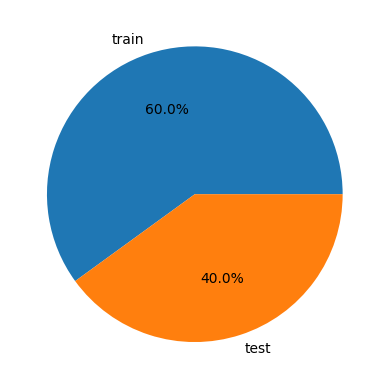

In [13]:
plt.pie([len(train_set), len(test_set)], labels=['train', 'test'], autopct="%1.1f%%")
print(f'train: {len(train_set)}')
print(f'test:  {len(test_set)}')
print('-------------')
print(f'sum:  {len(data_set)}')

In [51]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32033 entries, 0 to 32032
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              32033 non-null  int64  
 1   X_Maximum              32033 non-null  int64  
 2   Y_Minimum              32033 non-null  int64  
 3   Y_Maximum              32033 non-null  int64  
 4   Pixels_Areas           32033 non-null  int64  
 5   X_Perimeter            32033 non-null  int64  
 6   Y_Perimeter            32033 non-null  int64  
 7   Sum_of_Luminosity      32033 non-null  int64  
 8   Minimum_of_Luminosity  32033 non-null  int64  
 9   Maximum_of_Luminosity  32033 non-null  int64  
 10  Length_of_Conveyer     32033 non-null  int64  
 11  TypeOfSteel_A300       32033 non-null  int64  
 12  TypeOfSteel_A400       32033 non-null  int64  
 13  Steel_Plate_Thickness  32033 non-null  int64  
 14  Edges_Index            32033 non-null  float64
 15  Em

特徴量の説明
* [X_Minimum, X_Maximum]: 故障位置(x軸)
* [Y_Minimum, Y_Maximum]: 故障位置(y軸)
* Pixels_Areas: 故障面積(pixel単位)
* X_Perimeter, Y_Perimeter: 故障領域の周長(x軸, y軸)
* Sum_of_Luminosity: 故障領域の輝度値の合計
* Minimum_of_Luminosity, Maximum_of_Luminosity: 故障領域の輝度値(最小, 最大)
* Length_of_Conveyer: コンベアの長さ(鋼板本体の特徴ではない)
* TypeOfSteel_A300, TypeOfSteel_A400: 鋼板の種類(全ての鋼板がどちらかに割り当てられる(0or1))
* Steel_Plate_Thickness: 鋼板の厚さ
* Edges_Index, ..., Outside_Global_Index: 様々なインデックス値
* LogOfAreas: 故障領域の対数?
* Log_X_Index, Log_Y_Index: 対数インデックス(x軸, y軸)
* Orientation_Index: 方向インデックス
* Luminosity_Index: 輝度インデックス
* SigmoidOfAreas: 故障領域に適用されるシグモイド関数
---
* Pastry: 鋼板表面上の小さな斑点や凹凸
* Z_Scratch: 圧延方向と平行に走る鋼板表面上の狭い傷
* K_Scatch: 圧延方向に垂直に走る鋼板表面上の狭い傷
* Stains: 鋼板表面上の変色や汚染
* Dirtiness: 鋼板表面上の粒子状物質や汚れ
* Bumps: 鋼板表面上の隆起や突起
* Other_Faults: その他

In [4]:
# ターゲットリスト
target = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

Pastry         : 1466
Z_Scratch      : 1150
K_Scatch       : 3432
Stains         : 568
Dirtiness      : 485
Bumps          : 4763
Other_Faults   : 6558


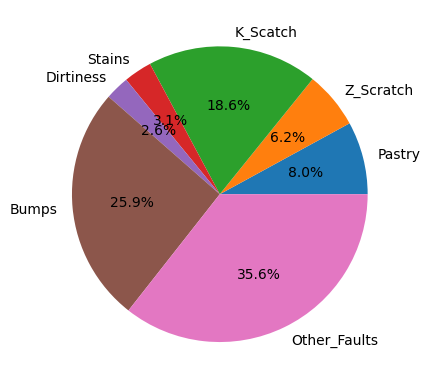

In [40]:
# クラス間比率
plt.pie([(train_set[i] == 1).sum() for i in target], labels=target, autopct="%1.1f%%")
for name, val in zip(target, [(train_set[i] == 1).sum() for i in target]):
    print('{:<15}: {}'.format(name, val))

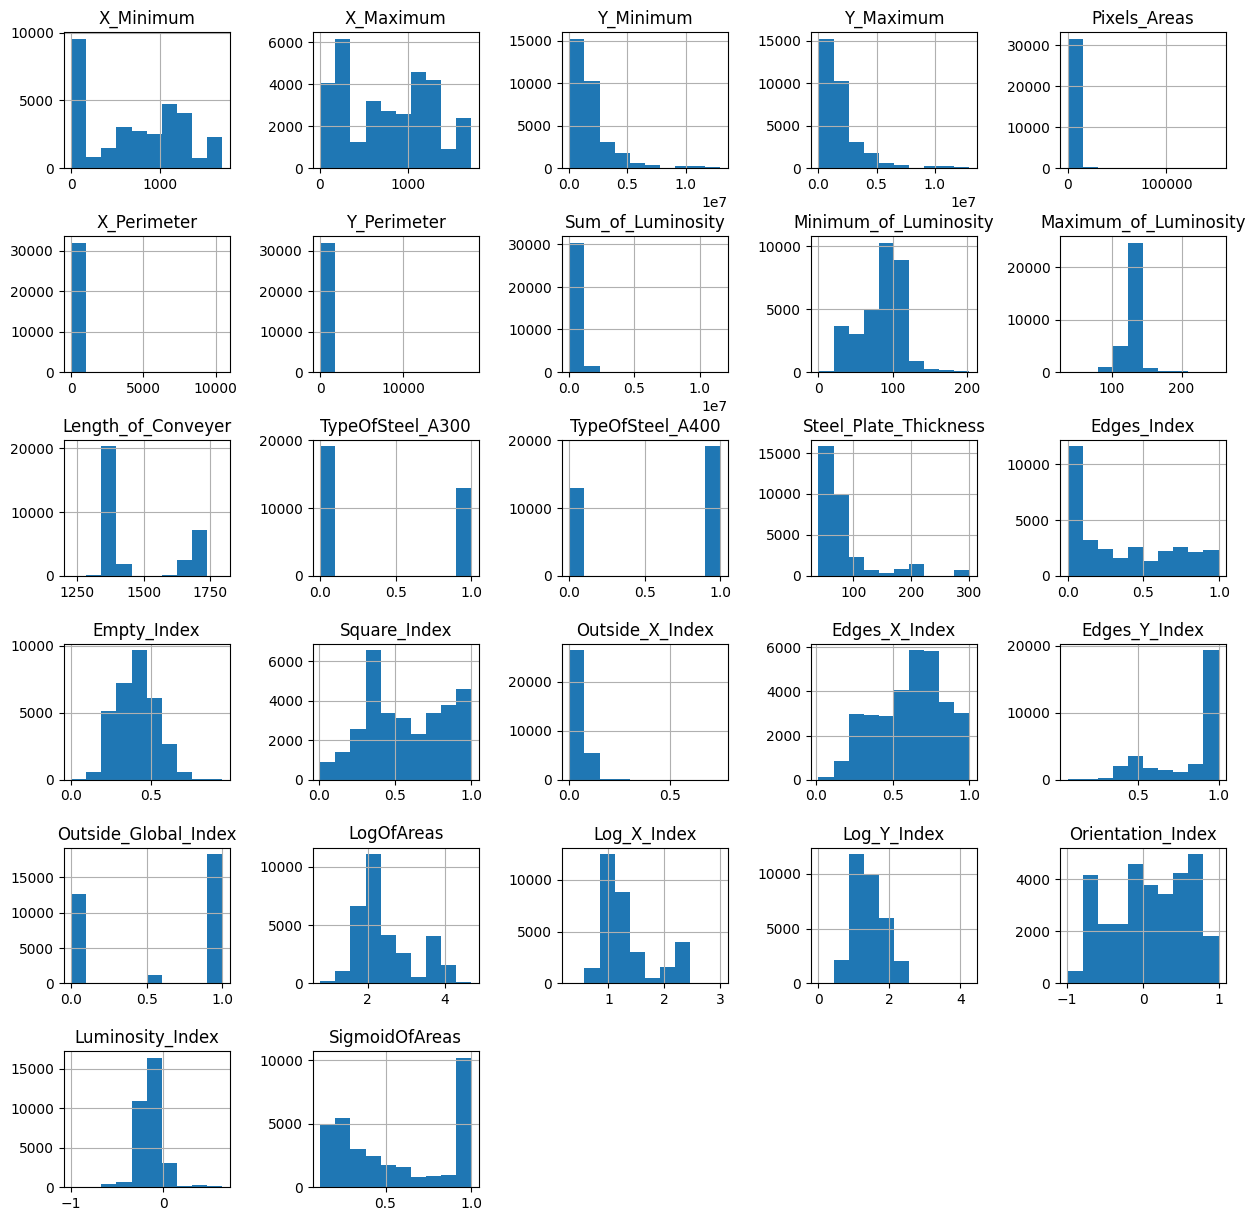

In [55]:
# 各特徴量ごとのヒストグラム
data_set.loc[:, :'SigmoidOfAreas'].hist(figsize=(15,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5) #グラフ間の幅調整

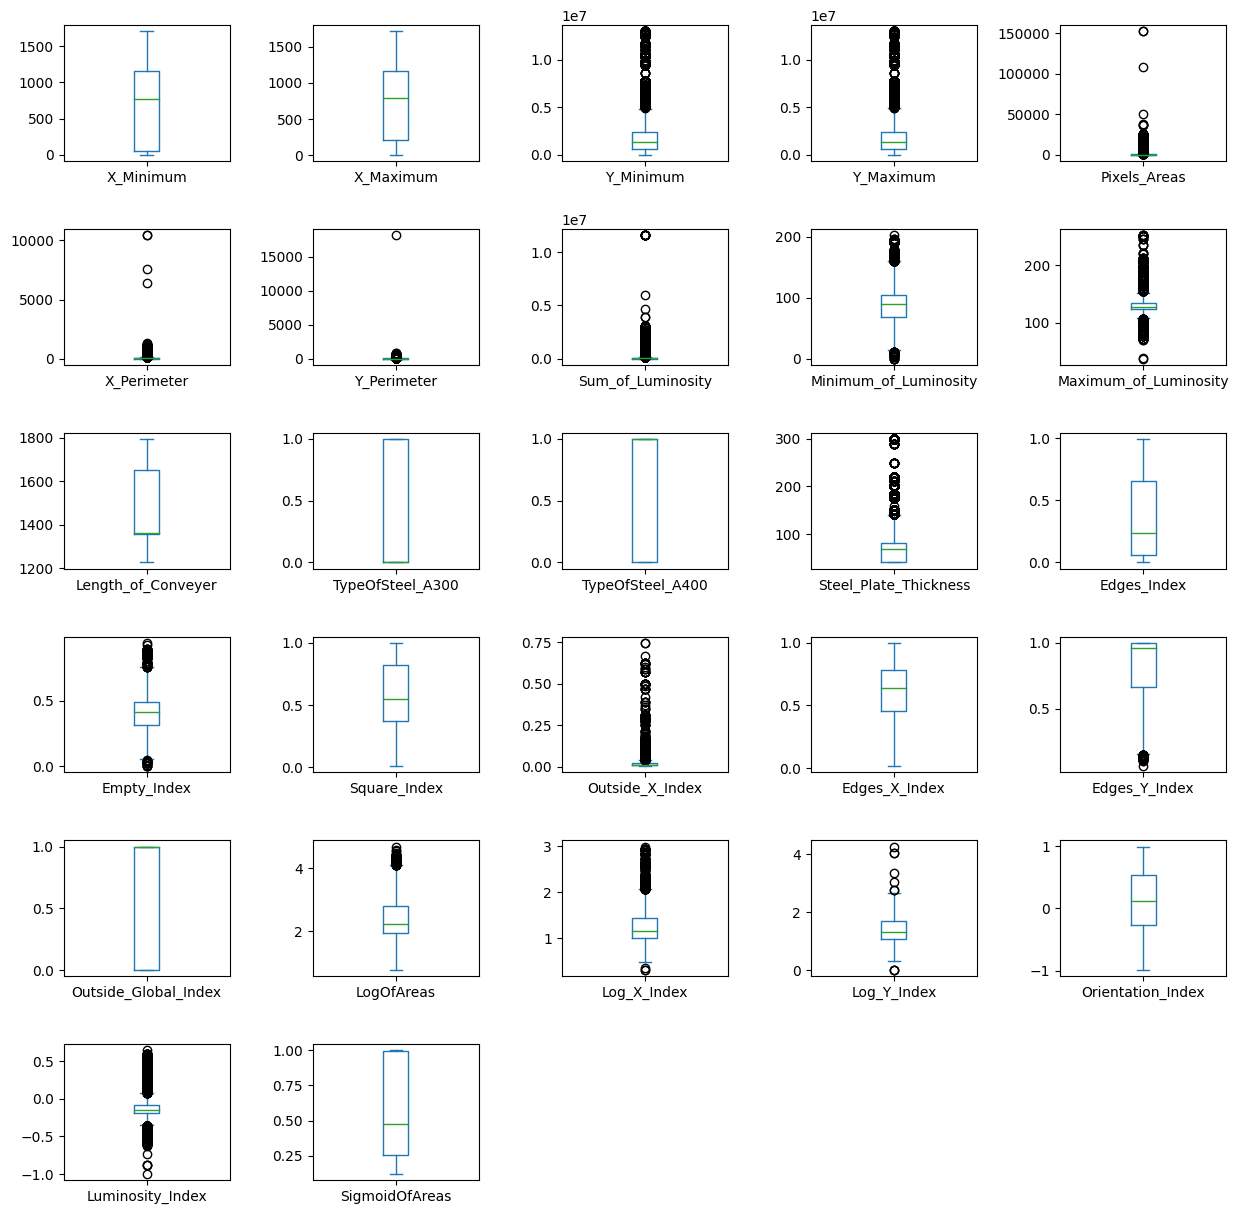

In [59]:
# 各特徴量ごとの箱髭図
# 左上の'1e7'はy軸の指数表記
'''
外れ値と識別されているデータの中でも, 特に以下の特徴量は外れ具合が激しい
・Pixels_Areas
・X_perimeter
・Y_perimeter
・Sum_of_Luminosity
'''
data_set.loc[:, :'SigmoidOfAreas'].plot(kind='box', layout=(6,5), subplots=True, sharex=False, sharey=False, figsize=(15,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [44]:
# 訓練データの各データポイントごとのラベル数
for i in [0, 1, 2]:
    print(f'labels={i}: {len(np.where(train_set[target].sum(axis=1) == i)[0])}')

labels=0: 818
labels=1: 18380
labels=2: 21


# 特徴量エンジニアリング

**外れ値処理**

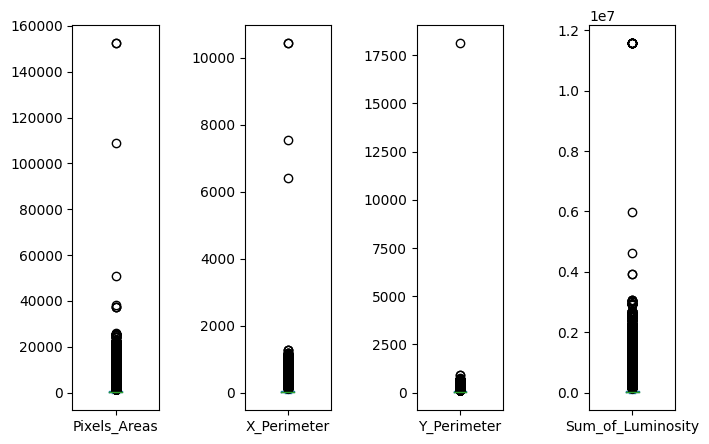

In [44]:
# 箱ひげ図
data_set.loc[:, 'Pixels_Areas':'Sum_of_Luminosity'].plot(kind='box', layout=(1,5), subplots=True, sharex=False, sharey=False, figsize=(10, 5))
plt.subplots_adjust(wspace=1.0, hspace=0.5)

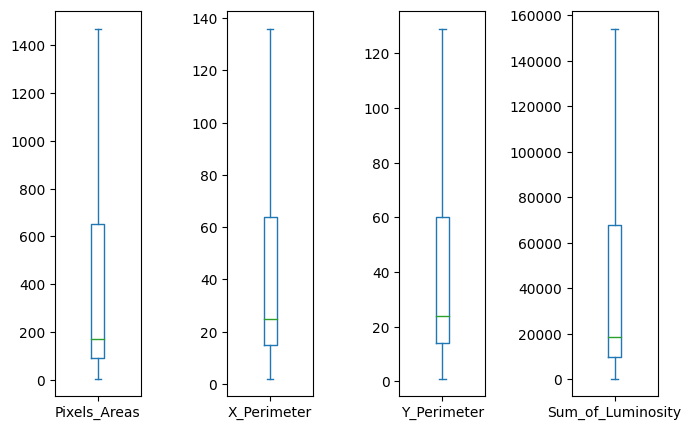

In [33]:
# 外れ値を除外した箱ひげ図
data_set.loc[:, 'Pixels_Areas':'Sum_of_Luminosity'].plot(kind='box', layout=(1,5), subplots=True, sharex=False, sharey=False, figsize=(10, 5), sym='')
plt.subplots_adjust(wspace=1.0, hspace=0.5)

In [73]:
# 外れ値と判定されたおおよその数
print(f'Pixels_Areas      : {len(data_set[data_set.Pixels_Areas >= 1500])}')
print(f'X_Perimeter       : {len(data_set[data_set.X_Perimeter >= 138])}')
print(f'Y_Perimeter       : {len(data_set[data_set.Y_Perimeter >= 130])}')
print(f'Sum_of_Luminosity : {len(data_set[data_set.Sum_of_Luminosity >= 157000])}')

Pixels_Areas      : 6193
X_Perimeter       : 6171
Y_Perimeter       : 4856
Sum_of_Luminosity : 6345


In [62]:
# Pixels_Areasの外れ値のラベル
'''
K_Scatchである3432個のデータ中, Pixels_Areas>=1500 のデータに3026含まれている
Pixels_Areasの外れ値はほとんどがK_Scatch/Other_Faults
'''
train_set.loc[:, 'Pastry':'Other_Faults'][train_set.Pixels_Areas >= 1500].value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          1         0       0          0      0               3026
                   0         0       0          0      1                410
                                                       0                 81
        1          0         0       0          0      0                 64
        0          0         0       0          1      0                 54
1       0          0         0       0          0      0                 53
0       0          1         0       0          0      1                 17
                   0         0       1          0      0                 15
                   1         0       0          1      0                  1
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

In [63]:
# X_Perimeterの外れ値のラベル
train_set.loc[:, 'Pastry':'Other_Faults'][train_set.X_Perimeter >= 138].value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          1         0       0          0      0               3040
                   0         0       0          0      1                409
                                                       0                 88
        1          0         0       0          0      0                 60
        0          0         0       0          1      0                 57
1       0          0         0       0          0      0                 35
0       0          1         0       0          0      1                 17
                   0         0       1          0      0                  9
                   1         0       0          1      0                  1
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

In [72]:
# Y_Perimeterの外れ値のラベル
train_set.loc[:, 'Pastry':'Other_Faults'][train_set.Y_Perimeter >= 130].value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          1         0       0          0      0               2355
                   0         0       0          0      1                319
                                                       0                 69
1       0          0         0       0          0      0                 68
0       1          0         0       0          0      0                 43
        0          0         0       0          1      0                 41
                                     1          0      0                 28
                   1         0       0          0      1                 17
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

In [69]:
# Sum_of_Luminosityの外れ値のラベル
train_set.loc[:, 'Pastry':'Other_Faults'][train_set.Sum_of_Luminosity >= 157000].value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          1         0       0          0      0               3017
                   0         0       0          0      1                455
                                                1      0                 92
                                                0      0                 90
        1          0         0       0          0      0                 69
1       0          0         0       0          0      0                 56
0       0          0         0       1          0      0                 22
                   1         0       0          0      1                 17
                                                1      0                  1
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

* ここでビニング->ワンホットエンコーディングで特徴量を増やしてしまうと、相関係数をヒートマップで表すことができない
* ビニングするのはスケーリングの前

**特徴量の追加**

In [5]:
# 故障の幅 ※必ずしもMaximum > Minimum ではない
data_set['X_Width'] = np.abs(data_set['X_Maximum'] - data_set['X_Minimum'])
data_set['Y_Width'] = np.abs(data_set['Y_Maximum'] - data_set['Y_Minimum'])

# 周長のxy比率
data_set['Ratio_Perimeter'] = data_set['X_Perimeter'] / data_set['Y_Perimeter']

# 故障面積に対する周長比 (大きいほど不規則な形をしている)
data_set['Density'] = data_set['Pixels_Areas'] / (data_set['X_Perimeter'] + data_set['Y_Perimeter'])

# 全体の形状
data_set['Shape'] = np.abs(data_set['X_Width'] - data_set['Y_Width']) / (data_set['X_Width'] + data_set['Y_Width'])

#輝度の差
data_set['Diff_of_Luminosity'] = np.abs(data_set['Maximum_of_Luminosity'] - data_set['Minimum_of_Luminosity'])

In [6]:
# ターゲットを末尾に移動
data_set = data_set[[col for col in data_set.columns if col not in target] + target]

In [7]:
# 訓練/テスト分割
train = data_set[data_set.Pastry.notna()]
test = data_set[data_set.Pastry.isna()]

**相関係数**

<Axes: >

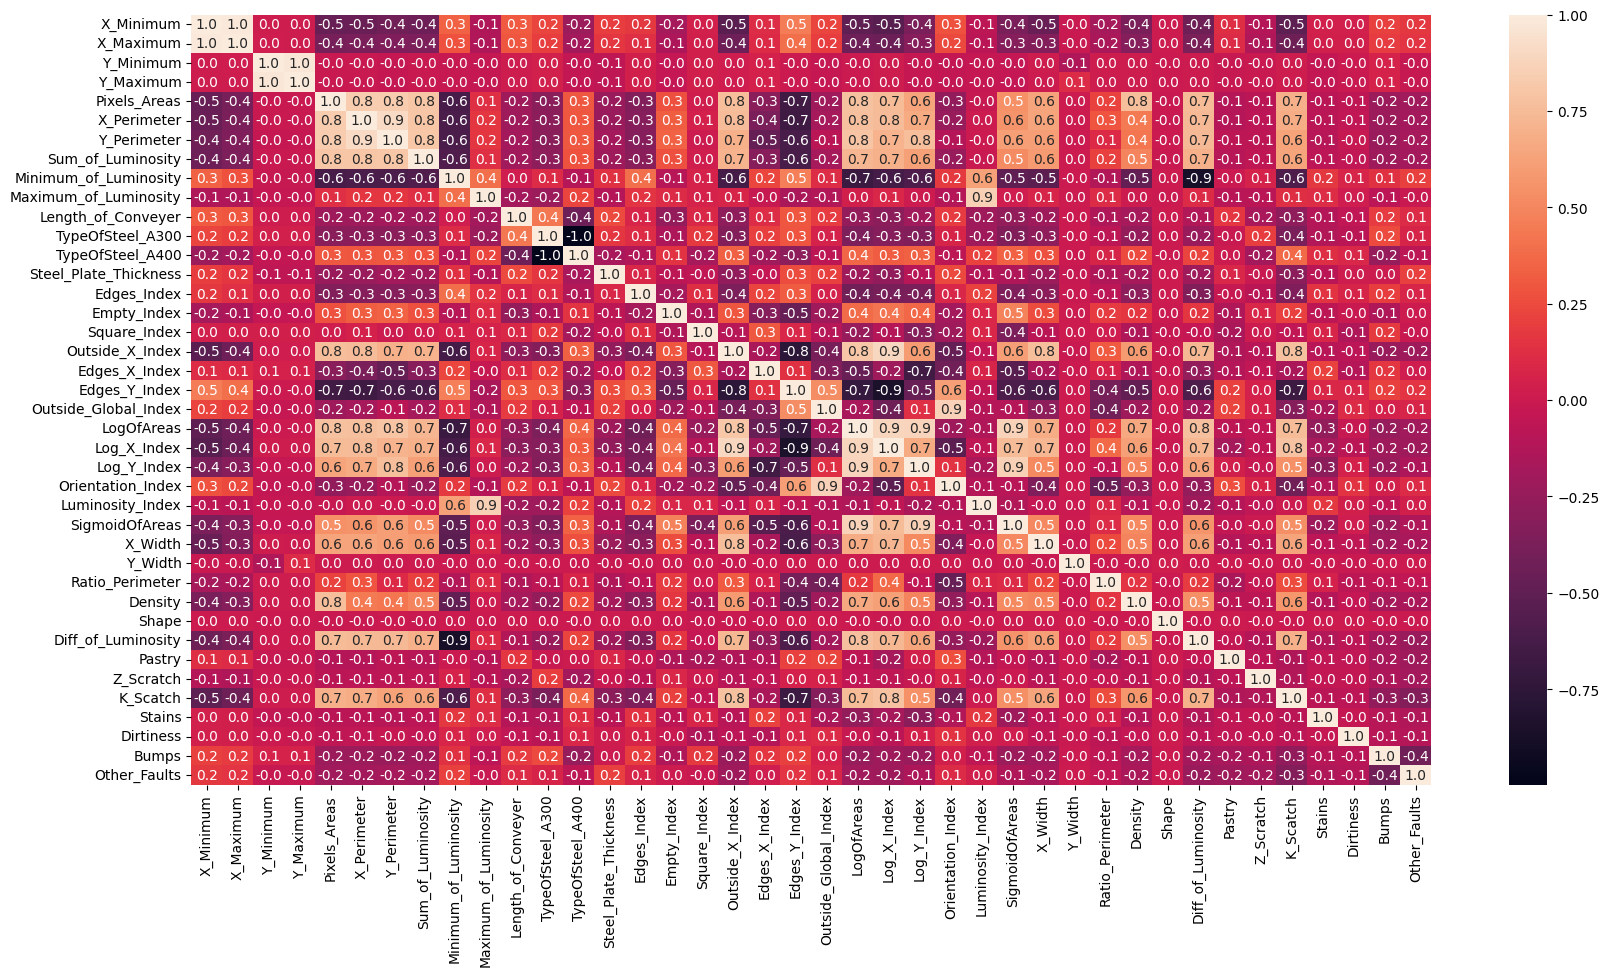

In [8]:
# 相関係数 (ビニング前)
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(),
            yticklabels=1,
            annot=True,
            fmt="1.1f")

<Axes: >

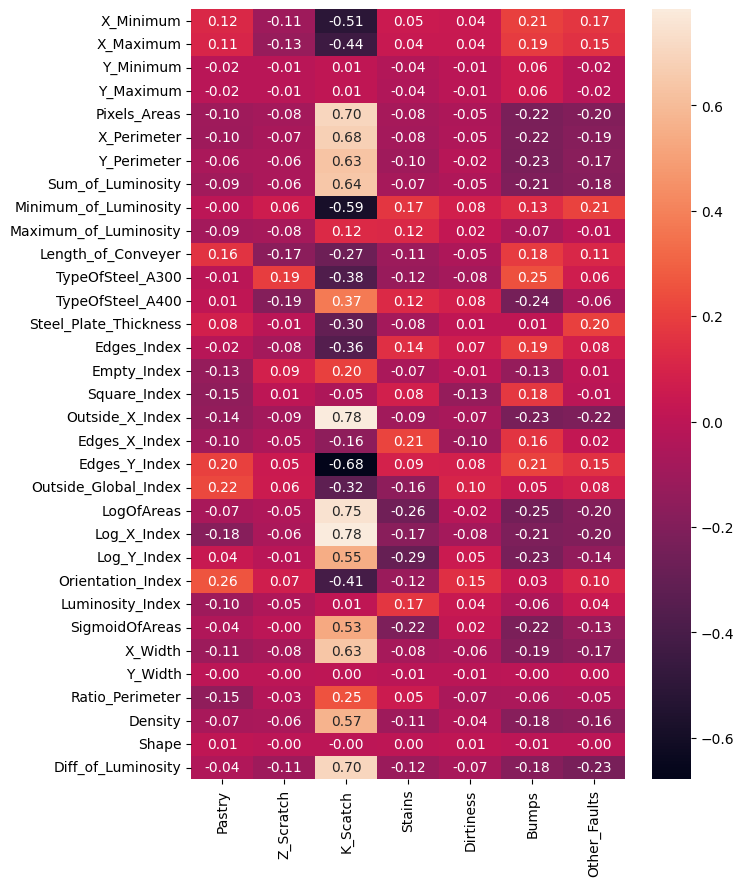

In [10]:
# 各ターゲットごとの各特徴量に対する相関係数 (ビニング前)
plt.figure(figsize=(7, 10))
sns.heatmap(train.corr().loc[target].drop(target, axis=1).T,
            yticklabels=1,
            annot=True,
            fmt="1.2f")

<Axes: >

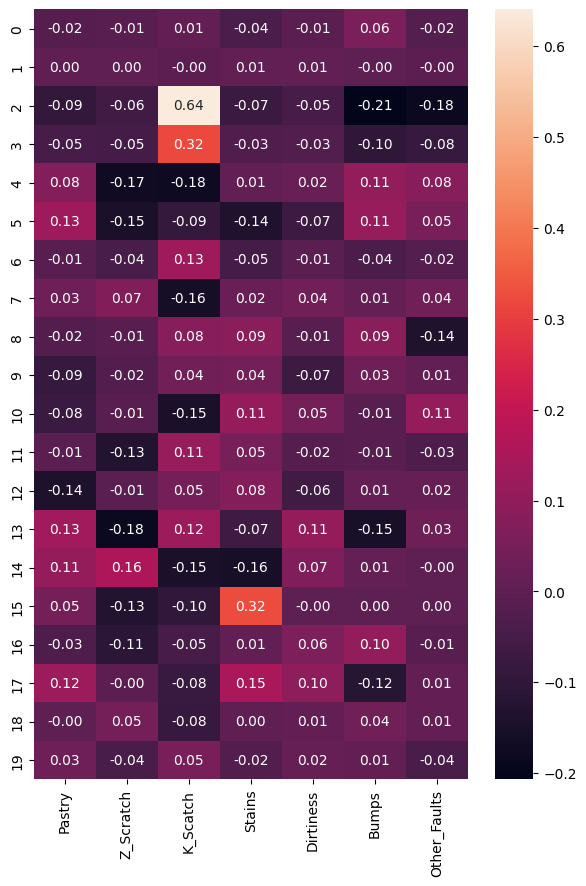

In [106]:
# PCA変換 (確認, ビニング前)
pca = pd.DataFrame(PCA(n_components=20).fit_transform(train.drop(target, axis=1)))
pca[target] = train[target]
plt.figure(figsize=(7, 10))
sns.heatmap(pca.corr().loc[target].drop(target, axis=1).T,
            yticklabels=1,
            annot=True,
            fmt="1.2f")

<Axes: >

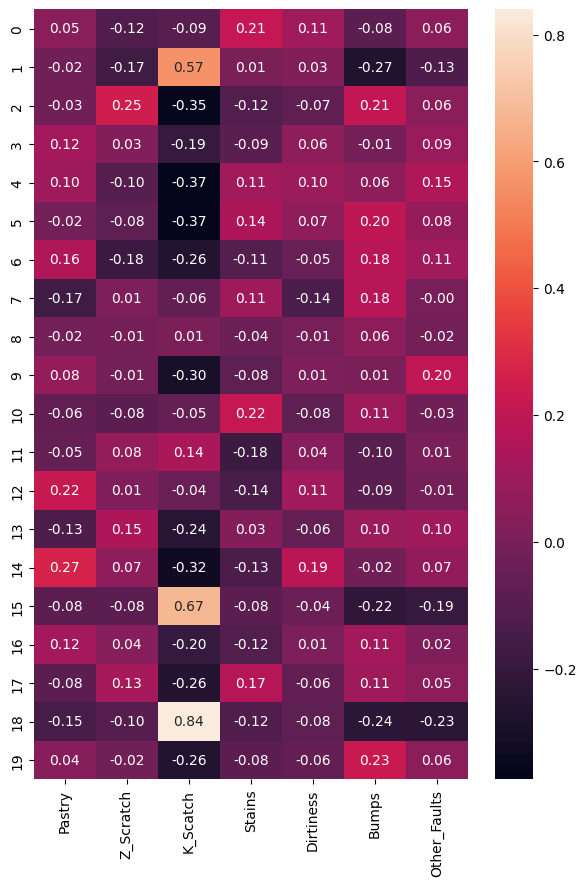

In [112]:
# NMF変換 (確認, ビニング前)
mn = MinMaxScaler().fit_transform(train.drop(target, axis=1))
nmf = pd.DataFrame(NMF(n_components=20, random_state=0).fit_transform(mn))
nmf[target] = train[target]
plt.figure(figsize=(7, 10))
sns.heatmap(nmf.corr().loc[target].drop(target, axis=1).T,
            yticklabels=1,
            annot=True,
            fmt="1.2f")

**学習/テストに必要な特徴量エンジニアリング**

ビニングをするとROC_AUCが2%低下、正しく調性しないと精度低下につながる

In [40]:
# ビニング (カテゴリ変数化)
labels=['1', '2', '3', '4', '5']
data_set['Pixels_Areas_qcut'] = pd.qcut(data_set['Pixels_Areas'], 5, labels=labels)

labels=['1', '2', '3', '4', '5']
data_set['X_Perimeter_qcut'] = pd.qcut(data_set['X_Perimeter'], 5, labels=labels)

labels=['1', '2', '3', '4', '5', '6']
data_set['Y_Perimeter_qcut'] = pd.qcut(data_set['Y_Perimeter'], 6, labels=labels)

labels=['1', '2', '3', '4', '5']
data_set['Sum_of_Luminosity_qcut'] = pd.qcut(data_set['Sum_of_Luminosity'], 5, labels=labels)

In [41]:
# ワンホットエンコーディング
data_set = pd.get_dummies(data_set, dtype='int64')
data_set.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'X_Width', 'Y_Width', 'Ratio_Perimeter', 'Density',
       'Shape', 'Diff_of_Luminosity', 'Pastry', 'Z_Scratch', 'K_Scatch',
       'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Pixels_Areas_qcut_1',
       'Pixels_Areas_qcut_2', 'Pixels_Areas_qcut_3', 'Pixels_Areas_qcut_4',
       'Pixels_Areas_qcut_5', 'X_Perimeter_qcut_1', 'X_Perimeter_qcut_2',
       'X_Perimeter_qcut_3', 'X_Perimeter_qcut_4', 'X_Perimeter_qcut_5',
       'Y_Perimeter_qcut_1', 'Y_Peri

In [42]:
# ビニング元の特徴量を除去
data_set = data_set.drop(['Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity'], axis=1)

In [7]:
# スケール変換 (訓練/テスト同時)
data = MinMaxScaler().fit_transform(data_set)
data = pd.DataFrame(data, columns=data_set.columns)

In [8]:
# 訓練/テスト分割
train = data[data.Pastry.notna()]
test = data[data.Pastry.isna()] 

In [9]:
#訓練データにおいて、ラベル数が1でないデータポイントはノイズとして除去
'''
全体19200のうち, およそ900のデータを除去するのは適切でない可能性がある
データの除去は慎重に
'''
train = train.drop(np.concatenate([np.where(train_set[target].sum(axis=1) == 0)[0],
                                   np.where(train_set[target].sum(axis=1) == 2)[0]]),
                   axis=0)
train = train.reset_index(drop=True) #インデックスの振りなおし
print(len(train))

18380


In [10]:
# 特徴量/ターゲット分割
X_train = train.drop(target, axis=1) #訓練データ
y_train = train[target] #訓練ターゲット
X_test = test.drop(target, axis=1) #テストデータ

In [11]:
# NMF変換
nmf = NMF(n_components=20, random_state=0).fit(X_train)
X_train = nmf.transform(X_train)
X_test = nmf.transform(X_test)

# 学習/予測

In [12]:
# 予測と提出用df作成
output = pd.DataFrame({'id': np.array(range(len(train_set), len(data_set)))})

**モデルの比較**
* PyCaretはバージョンが古い(?)ため使用できない
* predict_probaが使用できないモデルもあるため, 正解率で比較

In [75]:
# 比較用データ
y_train_class = pd.DataFrame({'Class': [np.nan]*len(y_train)})
for i, name in enumerate(target):
    y_train_class['Class'][y_train[name] == 1] = i

X_trn, X_val, y_trn, y_val = train_test_split(X_train,
                                              y_train_class,
                                              test_size=0.3,
                                              stratify=y_train,
                                              random_state=0)

In [76]:
#Logistic回帰
lr = LogisticRegression().fit(X_trn, y_trn)
y_pred = lr.predict(X_val)
print('lr        : {:.3f}'.format(accuracy_score(y_val, y_pred)))

#線形SVM
linear_svc = LinearSVC().fit(X_trn, y_trn)
y_pred = linear_svc.predict(X_val)
print('linear_svc: {:.3f}'.format(accuracy_score(y_val, y_pred)))

#カーネルSVM
svc = SVC().fit(X_trn, y_trn)
y_pred = svc.predict(X_val)
print('svc       : {:.3f}'.format(accuracy_score(y_val, y_pred)))

#k近傍法
knn = KNeighborsClassifier().fit(X_trn, y_trn)
y_pred = knn.predict(X_val)
print('knn       : {:.3f}'.format(accuracy_score(y_val, y_pred)))

#決定木
dec = DecisionTreeClassifier().fit(X_trn, y_trn)
y_pred = dec.predict(X_val)
print('dec       : {:.3f}'.format(accuracy_score(y_val, y_pred)))

#ランダムフォレスト
ran = RandomForestClassifier().fit(X_trn, y_trn)
y_pred = ran.predict(X_val)
print('ran       : {:.3f}'.format(accuracy_score(y_val, y_pred)))

#LightGBM
lgbm = lgb.LGBMClassifier().fit(X_trn, y_trn)
y_pred = lgbm.predict(X_val)
print('lgbm      : {:.3f}'.format(accuracy_score(y_val, y_pred)))

#XGBoost
xgbt = xgb.XGBClassifier().fit(X_trn, y_trn)
y_pred = xgbt.predict(X_val)
print('xgbt      : {:.3f}'.format(accuracy_score(y_val, y_pred)))

lr        : 0.520
linear_svc: 0.554
svc       : 0.565
knn       : 0.499
dec       : 0.485
ran       : 0.586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 12866, number of used features: 20
[LightGBM] [Info] Start training from score -2.529896
[LightGBM] [Info] Start training from score -2.771501
[LightGBM] [Info] Start training from score -1.684132
[LightGBM] [Info] Start training from score -3.475891
[LightGBM] [Info] Start training from score -3.636343
[LightGBM] [Info] Start training from score -1.350715
[LightGBM] [Info] Start training from score -1.033326
lgbm      : 0.588
xgbt      : 0.577


**ランダムフォレスト(不均衡重み付与)**

In [80]:
# ランダムフォレスト
clf = RandomForestClassifier(random_state=10, max_features='sqrt', class_weight='balanced')

# パイプライン
pipe = Pipeline([('classify', clf)])
param_test = {'classify__n_estimators': list(range(10, 14, 1)),
              'classify__max_depth': list(range(6, 10, 1))}

# グリッドサーチ
grid = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='roc_auc', cv=10)
grid.fit(X_train, y_train)
print('best_params_: {}\nbest_score_: {:.3f}'.format(grid.best_params_, grid.best_score_))

best_params_: {'classify__max_depth': 9, 'classify__n_estimators': 13}
best_score_: 0.849


In [83]:
# 予測
for i, t in enumerate(target):
    output[t] = grid.predict_proba(X_test)[i][:, 1]

**XGBoost**
* XGBを用いた多クラス分類では, ターゲットは1次元, 多次元どちらでも可能
* ただし, eval_setによる各イテレーションの検証スコア/アーリーストッピングは多次元をサポートしていない (1次元は不明)
* 今回はアーリーストッピングは使用せずにグリッドサーチを実行してみる (LGBMではアーリーストッピングを使用)

In [37]:
from sklearn.utils.class_weight import compute_sample_weight
weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

In [45]:
clf = xgb.XGBClassifier(learning_rate=0.1, eval_metric='auc', sample_weight=weight_train)

# パイプライン
pipe = Pipeline([('classify', clf)])
param_test = {'classify__n_estimators': list(range(10, 14, 1)),
              'classify__max_depth': list(range(5, 10, 1))}

# グリッドサーチ
grid = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='roc_auc', cv=10)
grid.fit(X_train, y_train)
print('best_params_: {}\nbest_score_: {:.3f}'.format(grid.best_params_, grid.best_score_))

best_params_: {'classify__max_depth': 7, 'classify__n_estimators': 13}
best_score_: 0.874


In [42]:
# 予測
for i, t in enumerate(target):
    output[t] = grid.predict_proba(X_test)[:, i]

**LightGBM**
* LGBMを用いた多クラス分類では, ターゲットは1次元(ex: [3, 5, 2,...])である必要がある
* 予測時にpredict_probaを用いることで, クラス毎の確率を求めることが可能

In [13]:
# ターゲットを1次元に変換
y_train_1d = pd.DataFrame({'Class': [np.nan]*len(y_train)})
for i, name in enumerate(target):
    y_train_1d['Class'][y_train[name] == 1] = i
    
# アーリーストッピング用
X_trn, X_val, y_trn, y_val = train_test_split(X_train,
                                              y_train_1d,
                                              test_size=0.2,
                                              stratify=y_train_1d,
                                              random_state=0)

In [23]:
params = {'random_state': 0,
          'learning_rate': 0.1,
          'objective': 'multiclass',
          'metric': 'auc_mu',
          'early_stopping_rounds': 10,
          'num_class': len(target)}

clf = lgb.LGBMClassifier(**params)
clf.fit(X_trn,
        y_trn,
        eval_set=[(X_val, y_val)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=20, verbose=True),
            lgb.log_evaluation(100),
        ]
       )

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 14704, number of used features: 20
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score -2.529408
[LightGBM] [Info] Start training from score -2.771501
[LightGBM] [Info] Start training from score -1.684184
[LightGBM] [Info] Start training from score -3.477778
[LightGBM] [Info] Start training from score -3.634870
[LightGBM] [Info] Start training from score -1.350753
[LightGBM] [Info] Start training from score -1.033326
Training until validation scores don't improve for 20 rounds
Trai

LGBMClassifier(early_stopping_rounds=10, metric='auc_mu', num_class=7,
               objective='multiclass', random_state=0)

In [30]:
# 予測
for i, t in enumerate(target):
    output[t] = clf.predict_proba(X_test)[:, i]

**出力**

In [110]:
# CSV出力
output.to_csv('submission.csv', index=False)